In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [0]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [10]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.397568	Accuracy: 14.84375
Train: [12800/60000 (21%)]	Loss: 3.008540	Accuracy: 14.039522058823529
Train: [25600/60000 (43%)]	Loss: 1.976833	Accuracy: 18.599164603960396
Train: [38400/60000 (64%)]	Loss: 1.677648	Accuracy: 24.76200331125828
Train: [51200/60000 (85%)]	Loss: 0.990708	Accuracy: 34.74424751243781
Epoch: 1/20. Train set: Average loss: 1.7210	Accuracy: 41.95
Epoch: 1/20. Validation set: Average loss: 0.4182	Accuracy: 89.66
Train: [0/60000 (0%)]	Loss: 0.439234	Accuracy: 88.28125
Train: [12800/60000 (21%)]	Loss: 0.384648	Accuracy: 91.18412990196079
Train: [25600/60000 (43%)]	Loss: 0.323143	Accuracy: 91.98251856435644
Train: [38400/60000 (64%)]	Loss: 0.263252	Accuracy: 92.73592715231788
Train: [51200/60000 (85%)]	Loss: 0.223771	Accuracy: 93.42933768656717
Epoch: 2/20. Train set: Average loss: 0.2862	Accuracy: 93.76333333333334
Epoch: 2/20. Validation set: Average loss: 0.1904	Accuracy: 96.05
Train: [0/60000 (0%)]	Loss: 0.123619	Accuracy: 97.65625
Trai

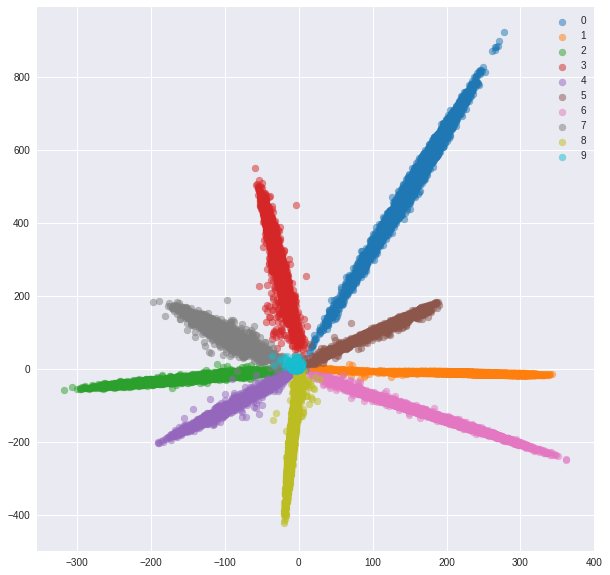

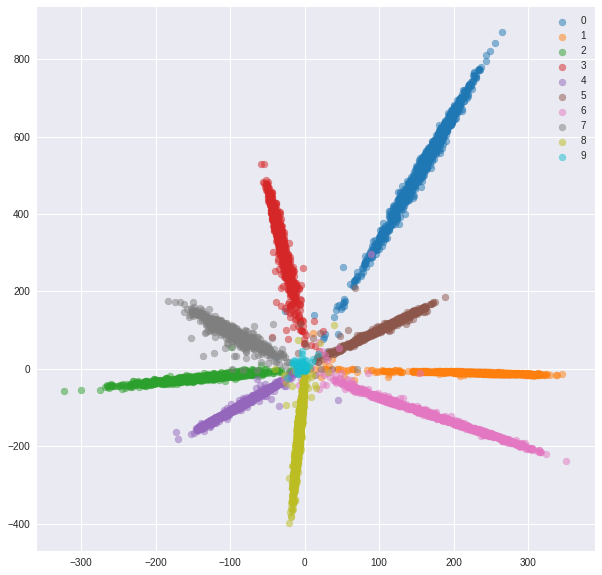

In [11]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [0]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [13]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.251023
Train: [12800/60000 (21%)]	Loss: 0.065513
Train: [25600/60000 (43%)]	Loss: 0.038856
Train: [38400/60000 (64%)]	Loss: 0.030183
Train: [51200/60000 (85%)]	Loss: 0.022259
Epoch: 1/20. Train set: Average loss: 0.0370
Epoch: 1/20. Validation set: Average loss: 0.0180
Train: [0/60000 (0%)]	Loss: 0.015461
Train: [12800/60000 (21%)]	Loss: 0.016330
Train: [25600/60000 (43%)]	Loss: 0.014597
Train: [38400/60000 (64%)]	Loss: 0.012566
Train: [51200/60000 (85%)]	Loss: 0.011178
Epoch: 2/20. Train set: Average loss: 0.0133
Epoch: 2/20. Validation set: Average loss: 0.0102
Train: [0/60000 (0%)]	Loss: 0.006078
Train: [12800/60000 (21%)]	Loss: 0.008926
Train: [25600/60000 (43%)]	Loss: 0.008502
Train: [38400/60000 (64%)]	Loss: 0.007410
Train: [51200/60000 (85%)]	Loss: 0.007589
Epoch: 3/20. Train set: Average loss: 0.0079
Epoch: 3/20. Validation set: Average loss: 0.0080
Train: [0/60000 (0%)]	Loss: 0.008172
Train: [12800/60000 (21%)]	Loss: 0.005822
Train: [25600/60000 (

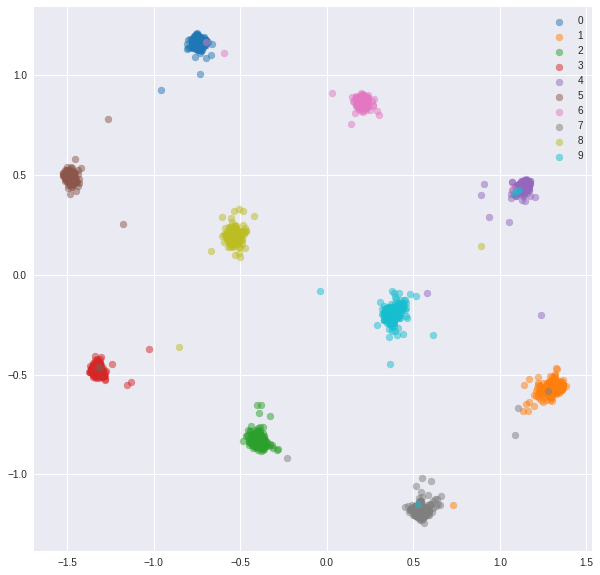

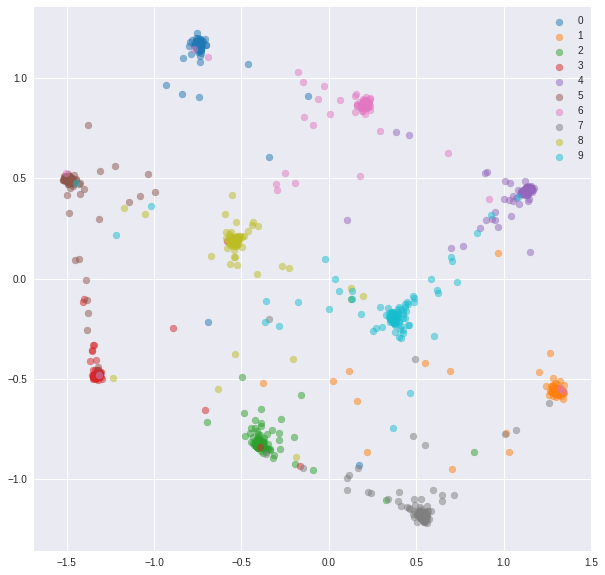

In [14]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$

In [0]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [16]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999611
Train: [12800/60000 (21%)]	Loss: 0.291173
Train: [25600/60000 (43%)]	Loss: 0.133367
Train: [38400/60000 (64%)]	Loss: 0.105884
Train: [51200/60000 (85%)]	Loss: 0.080248
Epoch: 1/20. Train set: Average loss: 0.1425
Epoch: 1/20. Validation set: Average loss: 0.0716
Train: [0/60000 (0%)]	Loss: 0.097012
Train: [12800/60000 (21%)]	Loss: 0.054052
Train: [25600/60000 (43%)]	Loss: 0.059432
Train: [38400/60000 (64%)]	Loss: 0.048997
Train: [51200/60000 (85%)]	Loss: 0.047125
Epoch: 2/20. Train set: Average loss: 0.0514
Epoch: 2/20. Validation set: Average loss: 0.0436
Train: [0/60000 (0%)]	Loss: 0.028000
Train: [12800/60000 (21%)]	Loss: 0.039745
Train: [25600/60000 (43%)]	Loss: 0.027855
Train: [38400/60000 (64%)]	Loss: 0.033542
Train: [51200/60000 (85%)]	Loss: 0.032535
Epoch: 3/20. Train set: Average loss: 0.0331
Epoch: 3/20. Validation set: Average loss: 0.0339
Train: [0/60000 (0%)]	Loss: 0.042692
Train: [12800/60000 (21%)]	Loss: 0.025005
Train: [25600/60000 (

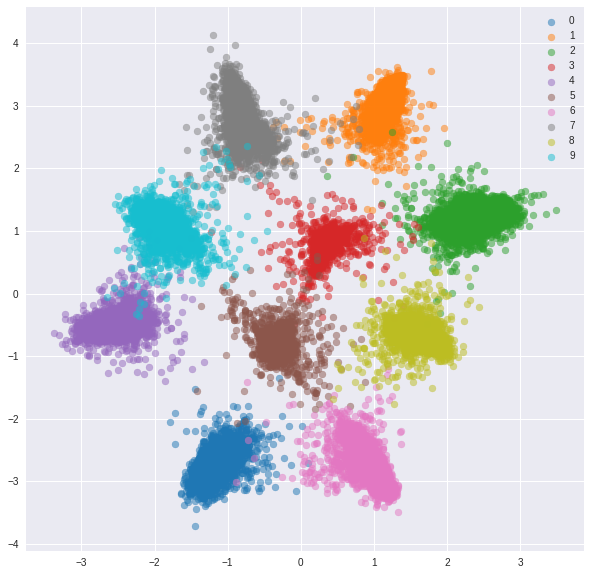

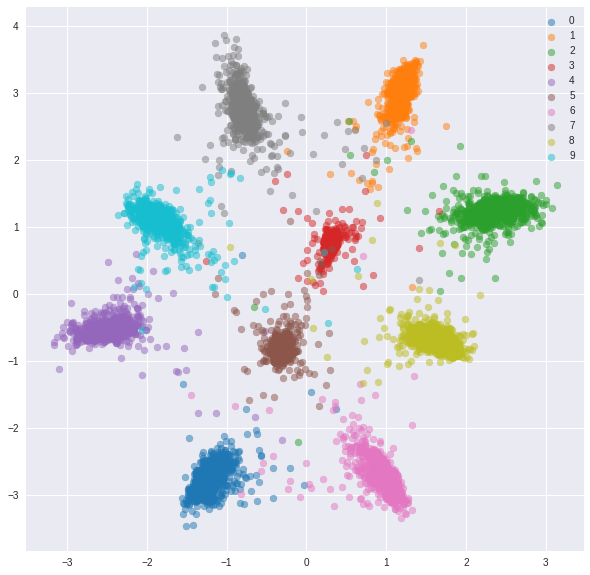

In [17]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [25]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.458707
Train: [12500/60000 (21%)]	Loss: 0.136189
Train: [25000/60000 (42%)]	Loss: 0.086443
Train: [37500/60000 (62%)]	Loss: 0.067244
Train: [50000/60000 (83%)]	Loss: 0.055883
Epoch: 1/20. Train set: Average loss: 0.0821
Epoch: 1/20. Validation set: Average loss: 0.0454
Train: [0/60000 (0%)]	Loss: 0.043295
Train: [12500/60000 (21%)]	Loss: 0.044116
Train: [25000/60000 (42%)]	Loss: 0.034832
Train: [37500/60000 (62%)]	Loss: 0.034999
Train: [50000/60000 (83%)]	Loss: 0.031684
Epoch: 2/20. Train set: Average loss: 0.0348
Epoch: 2/20. Validation set: Average loss: 0.0270
Train: [0/60000 (0%)]	Loss: 0.015340
Train: [12500/60000 (21%)]	Loss: 0.026183
Train: [25000/60000 (42%)]	Loss: 0.022989
Train: [37500/60000 (62%)]	Loss: 0.021104
Train: [50000/60000 (83%)]	Loss: 0.017935
Epoch: 3/20. Train set: Average loss: 0.0212
Epoch: 3/20. Validation set: Average loss: 0.0247
Train: [0/60000 (0%)]	Loss: 0.032484
Train: [12500/60000 (21%)]	Loss: 0.017106
Train: [25000/60000 (

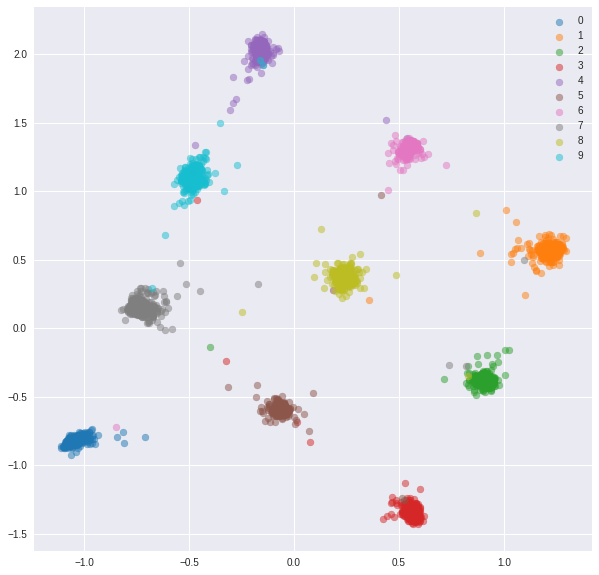

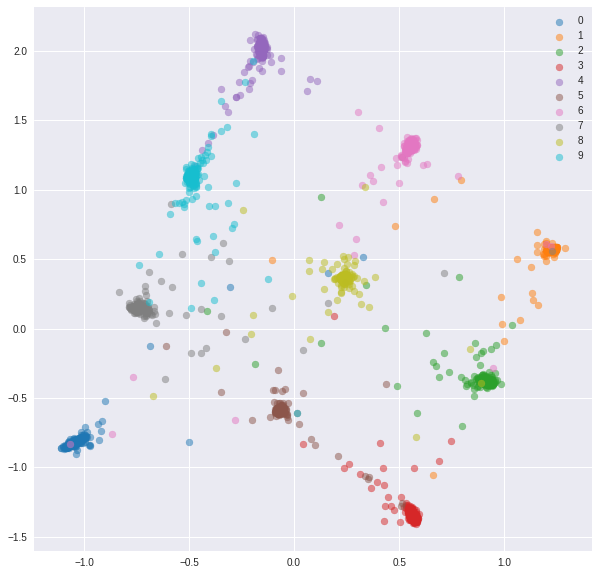

In [26]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

## Online triplet selection

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [22]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.998931	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.976308	Average nonzero triplets: 2589.7843137254904
Train: [25000/60000 (42%)]	Loss: 0.987329	Average nonzero triplets: 2166.891089108911
Train: [37500/60000 (62%)]	Loss: 0.969919	Average nonzero triplets: 1919.8940397350993
Train: [50000/60000 (83%)]	Loss: 0.958205	Average nonzero triplets: 1747.8756218905473
Epoch: 1/20. Train set: Average loss: 0.9771	Average nonzero triplets: 1633.4058577405858
Epoch: 1/20. Validation set: Average loss: 1.0349	Average nonzero triplets: 951.2820512820513
Train: [0/60000 (0%)]	Loss: 1.084398	Average nonzero triplets: 607.0
Train: [12500/60000 (21%)]	Loss: 0.975223	Average nonzero triplets: 828.4901960784314
Train: [25000/60000 (42%)]	Loss: 1.039955	Average nonzero triplets: 816.960396039604
Train: [37500/60000 (62%)]	Loss: 1.011074	Average nonzero triplets: 783.7814569536424
Train: [50000/60000 (83%)]	Loss: 0.997453	Average nonzero triplets: 751.0

Train: [50000/60000 (83%)]	Loss: 0.235304	Average nonzero triplets: 42.582089552238806
Epoch: 15/20. Train set: Average loss: 0.3171	Average nonzero triplets: 42.79497907949791
Epoch: 15/20. Validation set: Average loss: 0.9849	Average nonzero triplets: 321.79487179487177
Train: [0/60000 (0%)]	Loss: 0.000000	Average nonzero triplets: 1.0
Train: [12500/60000 (21%)]	Loss: 0.238029	Average nonzero triplets: 29.705882352941178
Train: [25000/60000 (42%)]	Loss: 0.225959	Average nonzero triplets: 40.495049504950494
Train: [37500/60000 (62%)]	Loss: 0.219658	Average nonzero triplets: 40.437086092715234
Train: [50000/60000 (83%)]	Loss: 0.307673	Average nonzero triplets: 36.72139303482587
Epoch: 16/20. Train set: Average loss: 0.2468	Average nonzero triplets: 34.52719665271967
Epoch: 16/20. Validation set: Average loss: 1.1743	Average nonzero triplets: 276.1025641025641
Train: [0/60000 (0%)]	Loss: 0.000000	Average nonzero triplets: 1.0
Train: [12500/60000 (21%)]	Loss: 0.247193	Average nonzero tri

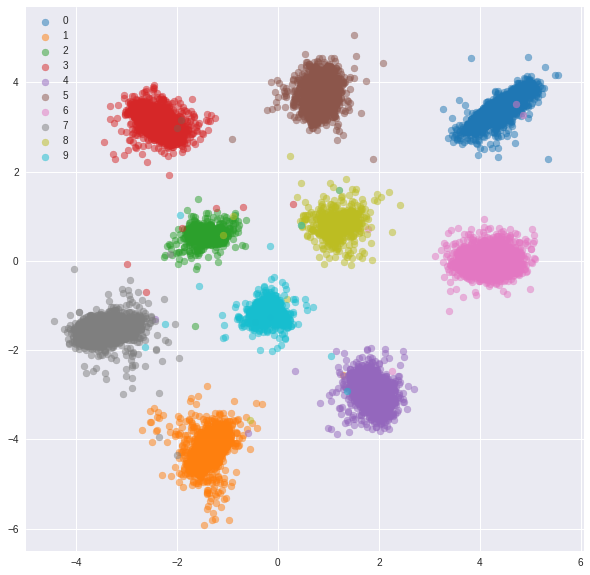

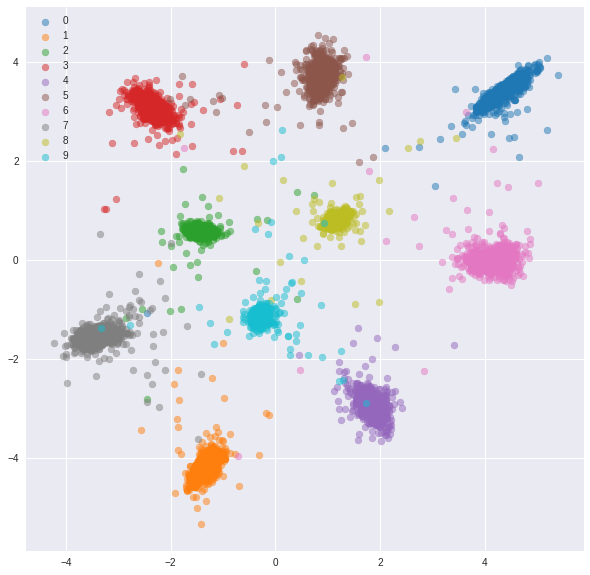

In [23]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)